In [1]:
%matplotlib notebook
from SimPEG import Mesh, Utils, PF
from SimPEG import Maps, Directives, InvProblem, Optimization, DataMisfit, Inversion, Regularization, mkvc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# Load a mesh and data
workDir = '.\\'
mesh = Mesh.TensorMesh.readUBC(workDir + 'Mesh_25m.msh')
survey = Utils.io_utils.readUBCmagneticsObservations(workDir + 'Obs_loc_TMI.obs')[0]

In [3]:
survey

In [4]:
def rotate(xyz, center, theta, phi):
    """
      Rotate scatter points in column format around a center location

      INPUT
      :param: xyz nDx3 matrix
      :param: center xyz location of rotation
      :param: theta angle rotation around x-axis
      :param: phi angle rotation around z-axis

    """
    xyz = xyz - np.kron(np.ones((xyz.shape[0], 1)), np.r_[center])

    phi = -np.deg2rad(np.asarray(inc))
    theta = -np.deg2rad(np.asarray(dec))

    Rx = np.asarray([[1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)]])

    Rz = np.asarray([[np.cos(theta), -np.sin(theta), 0],
                    [np.sin(theta), np.cos(theta), 0],
                    [0, 0, 1]])

    R = Rz.dot(Rx)
    
    xyzRot = R.dot(xyz.T).T + np.kron(np.ones((xyz.shape[0], 1)), np.r_[center])

    return xyzRot


        

In [5]:
# Define an upright prism by its limits
xn, yn, zn = np.c_[300, 500], np.c_[300, 700], np.c_[-300, -200]

# Create all 8 corners
X, Y, Z = np.meshgrid(xn, yn, zn)
pts = np.c_[Utils.mkvc(X), Utils.mkvc(Y), Utils.mkvc(Z)]

# Rotate the coordinates about its center
inc = -45
dec = 90
orig = np.r_[np.mean(np.r_[xn, yn, zn], axis=1)]
xyz = rotate(
    pts, orig,
    inc, dec
)
ind = Utils.ModelBuilder.PolygonInd(mesh, xyz)
            

<IPython.core.display.Javascript object>


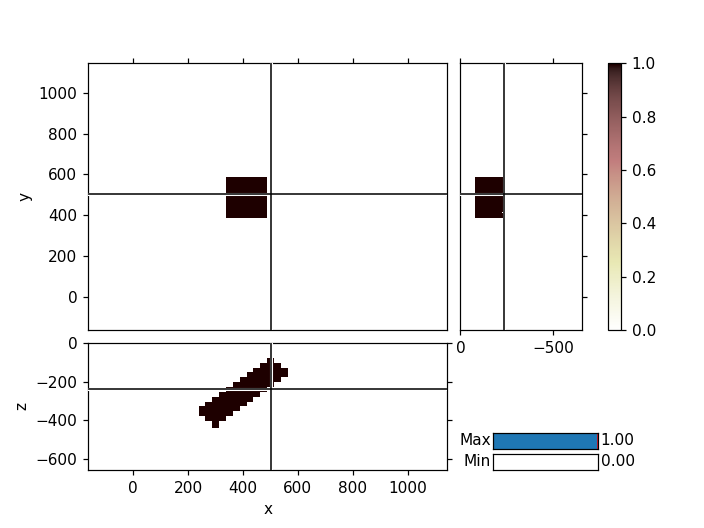

In [6]:
# Create active cells (all active)
actv = np.ones(mesh.nC, dtype='bool')

# Create the model from index
m = np.zeros(mesh.nC)
m[ind] = 1

mesh.plot_3d_slicer(m, transparent='slider', pcolorOpts={'cmap':'pink_r'})


# Define magnetization amplitude and orientation of space
mA = np.zeros(mesh.nC)
mT = np.ones(mesh.nC) * 90
mP = np.ones(mesh.nC) * 0

# Define magnetization amplitude and orientation of anomalie
mA[ind] = 0.01
mT[ind] = 45
mP[ind] = 90

# We create a magnetization model different than the inducing field
# to simulate remanent magnetization. Let's do something simple,
# reversely magnetized [45,90]
M = Utils.matutils.dipazm_2_xyz(mkvc(mT)[actv], mkvc(mP)[actv])

# Multiply the orientation with the effective susceptibility
# and reshape as [mx,my,mz] vector
m = mkvc(sp.sparse.diags(mA, 0) * M)

In [9]:


# Create reduced identity map
idenMap = Maps.IdentityMap(nP = int(3*mesh.nC))

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap = idenMap, modelType = 'vector', 
                                     actInd = actv, parallelized = True)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
data = prob.fields(m)

# Assign uncertainties
survey.std = np.ones(survey.nD) * np.percentile(np.abs(data), 10)

Begin forward: M=full, Rx type= tmi


<IPython.core.display.Javascript object>


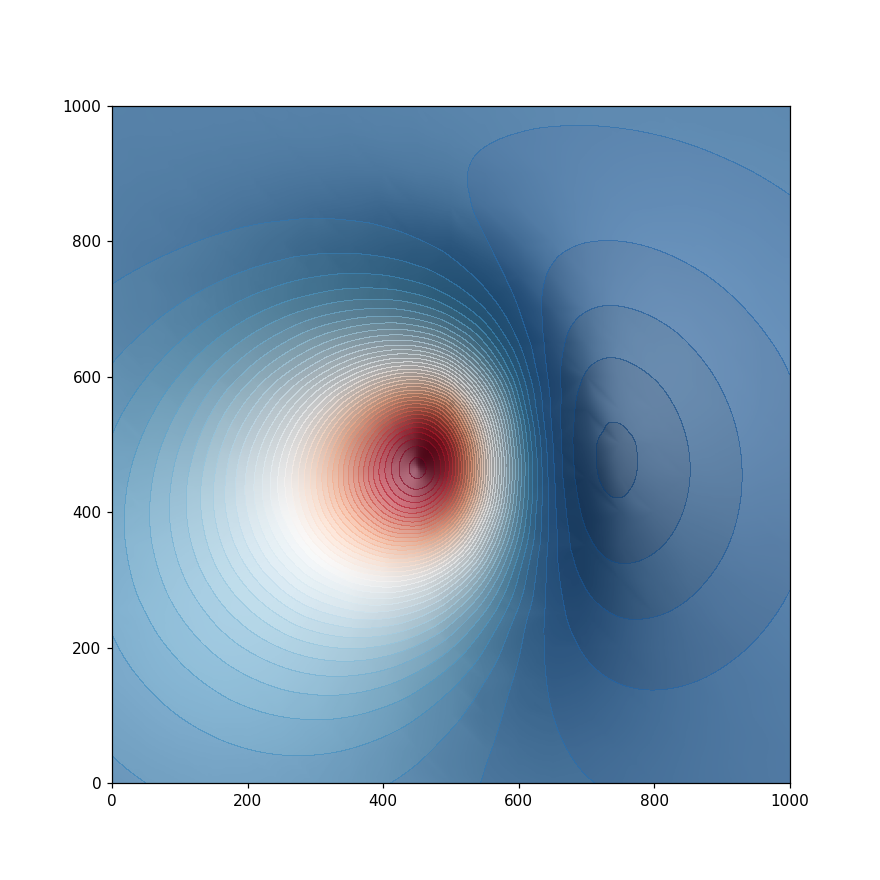

In [10]:
#We can plot the data, looks like this,
xyLocs = survey.srcField.rxList[0].locs
fig = plt.figure(figsize=(8,8))
axs = plt.subplot()
im,CS = Utils.PlotUtils.plotDataHillside(
    xyLocs[:,0], xyLocs[:,1], data,
    axs=axs, alpha=0.6,  alphaHS=1., altdeg=15,
    ve=100)

In [12]:
# Save the data to file
Utils.io_utils.writeUBCmagneticsObservations('SyntheticData.obs', survey, data)

# Write the model
Utils.io_utils.writeVectorUBC(mesh, 'VectorModel.fld', m.reshape((mesh.nC,3), order='F'))

Observation file saved to: SyntheticData.obs
